In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pathlib
import glob as glob

import hydra
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.observations import sample_obs
from cohlib.utils import add0, jax_boilerplate, pickle_save, pickle_open

import cohlib.confs.utils as conf
from cohlib.confs.latent import create_lrccn_basic_rank1
from cohlib.confs.config import get_sim_config

In [4]:
# Get plots for previously saved data with large oscillations / high rate

In [5]:
def mod_config(cfg, scale_power, K, L, theta):
    cfg.latent.L = L
    cfg.latent.scale_power_target = scale_power
    cfg.latent.K = K
    if cfg.obs.obs_type == 'gaussian':
        cfg.obs.ov2 = theta
    elif cfg.obs.obs_type in ['pp_relu', 'pp_log']:
        cfg.obs.mu = theta
    else:
        raise ValueError

    return cfg

def get_plot_dict(func, cfg, cfg_lr, scale_power, K, L, theta, seeds):
    cfg = mod_config(cfg, scale_power, K, L, theta)
    cfg_lr = mod_config(cfg_lr, scale_power, K, L, theta)
    plot_data = {}
    plot_data['true'] = []
    plot_data['oracle'] = []
    plot_data['model'] = []
    plot_data['model_lr'] = []
    plot_data['naive'] = []
    for s, seed_use in enumerate(seeds):
        true, oracle, model, model_lr, naive = func(cfg, cfg_lr, seed_use)
        plot_data['true'].append(true) 
        plot_data['oracle'].append(oracle)
        plot_data['model'].append(model)
        plot_data['model_lr'].append(model_lr)
        plot_data['naive'].append(naive)

    return plot_data

In [6]:
def get_ccn_fullrank_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals

In [17]:
from cohlib.utils import naive_estimator
from cohlib.plot import get_eigval

def get_theta_label(ocfg, theta):
    if ocfg.obs_type == 'gaussian':
        label = f'{ocfg.ov1}e{theta}'
    elif ocfg.obs_type in ['pp_relu', 'pp_log']:
        label = f'mu = {theta}'
    else:
        return ValueError
    return label

def get_ccn_fullrank_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals

def eigval1(cfg, cfg_lr, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    cfg_lr.latent.gamma_seed = gseed
    cfg_lr.latent.seed = seed
    cfg_lr.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigval_true = lrccn_true.eigvals[0,eigrank-1]

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
            
    model_dir = conf.get_model_dir(cfg, temp_params)
    res = pickle_open(os.path.join(model_dir, 'res.pkl'))
    eigval_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,eigrank-1]

    model_dir_lr = conf.get_model_dir(cfg_lr, temp_params)
    res_lr = pickle_open(os.path.join(model_dir_lr, 'res.pkl'))
    eigval_model_lr = get_ccn_fullrank_eigvals(res_lr['ccn_est'])[0,eigrank-1]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)

    return eigval_true, eigval_oracle, eigval_model, eigval_model_lr, eigval_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [18]:
def get_ccn_fullrank_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

In [19]:
from cohlib.plot import get_eigvec
from cohlib.utils import rotate_eigvecs
def eigvec1(cfg, cfg_lr, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    cfg_lr.latent.gamma_seed = gseed
    cfg_lr.latent.seed = seed
    cfg_lr.obs.seed = seed
    
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigvec_true = lrccn_true.eigvecs[0,:,eigrank-1]

    model_dir = conf.get_model_dir(cfg, temp_params)
    res = pickle_open(os.path.join(model_dir, 'res.pkl'))
    eigvec_model = rotate_eigvecs(get_ccn_fullrank_eigvecs(res['ccn_est']))[0,:,eigrank-1]

    model_dir_lr = conf.get_model_dir(cfg_lr, temp_params)
    res_lr = pickle_open(os.path.join(model_dir_lr, 'res.pkl'))
    eigvec_model_lr = get_ccn_fullrank_eigvecs(res_lr['ccn_est'])[0,:,eigrank-1]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigvec_oracle = get_eigvec(gamma_oracle[jind_nz,:,:], eigrank)
    eigvec_oracle = eigvec_oracle*jnp.exp(-1j*jnp.angle(eigvec_oracle[0]))

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigvec_naive = get_eigvec(naive_est[jind_nz,:,:], eigrank)
    eigvec_naive = eigvec_naive*jnp.exp(-1j*jnp.angle(eigvec_naive[0]))

    return eigvec_true, eigvec_oracle, eigvec_model, eigvec_model_lr, eigvec_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sampling_dists(ax, data_matrix, category_labels, jitter=False, jitter_strength=0.05, colors=None):
    """
    Plot data points from a matrix across multiple categories.

    Parameters:
    - data_matrix: numpy array or matrix of shape (N, C), with N data points per each of the C categories.
    - category_labels: List of category labels (length C).
    - jitter: Boolean indicating whether to jitter points along the x-axis.
    - jitter_strength: Magnitude of jitter applied along x-axis.
    """
    N, C = data_matrix.shape
    x_positions = np.arange(C)

    if colors is None:
        colors = ['tab:red', 'tab:blue', 'tab:green']


    for i in range(C):
        y = data_matrix[:, i]
        x = np.full(N, x_positions[i], dtype=float)

        if jitter:
            x += np.random.uniform(-jitter_strength, jitter_strength, size=N)

        ax.scatter(x, y, alpha=0.7, color=colors[i])
        # ax.scatter(x, y, alpha=0.7, edgecolors='k', color=colors[i])

    ax.set_xticks(x_positions, category_labels)
    plt.tight_layout()

In [21]:
def eigval_all(cfg, cfg_lr, seed, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    cfg_lr.latent.gamma_seed = gseed
    cfg_lr.latent.seed = seed
    cfg_lr.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigvals_true = lrccn_true.eigvals[0,:]

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}

    model_dir = conf.get_model_dir(cfg, temp_params)
    res = pickle_open(os.path.join(model_dir, 'res.pkl'))
    eigvals_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,:]

    model_dir_lr = conf.get_model_dir(cfg_lr, temp_params)
    res_lr = pickle_open(os.path.join(model_dir_lr, 'res.pkl'))
    eigvals_model_lr = get_ccn_fullrank_eigvals(res_lr['ccn_est'])[0,:]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigvals_oracle = jnp.linalg.eigh(gamma_oracle[jind_nz,:,:])[0][::-1]
    # eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    # eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)
    eigvals_naive = jnp.linalg.eigh(naive_est[jind_nz,:,:])[0][::-1]

    return eigvals_true, eigvals_oracle, eigvals_model, eigvals_model_lr, eigvals_naive

In [22]:
def gcoh(cfg, cfg_lr, seed, eigrank=1, gseed=0, jind_nz=0, lr_option='full'):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    cfg_lr.latent.gamma_seed = gseed
    cfg_lr.latent.seed = seed
    cfg_lr.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigval_true = lrccn_true.eigvals[0,eigrank-1]
    gcoh_true = eigval_true / lrccn_true.eigvals[0,:].sum()

    model_dir = conf.get_model_dir(cfg, temp_params)
    res = pickle_open(os.path.join(model_dir, 'res.pkl'))
    eigvals_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,:]
    gcoh_model = eigvals_model[eigrank-1] / eigvals_model.sum()

    model_dir_lr = conf.get_model_dir(cfg_lr, temp_params)
    res_lr = pickle_open(os.path.join(model_dir_lr, 'res.pkl'))
    eigvals_model_lr = get_ccn_fullrank_eigvals(res_lr['ccn_est'])[0,:]
    eigval_model_lr = eigvals_model_lr[eigrank-1]

    if lr_option == 'full':
        gcoh_model_lr = eigval_model_lr / eigvals_model_lr.sum()
    elif lr_option == 'bbh':
        gcoh_model_lr = eigval_model_lr / eigvals_model_lr[:3].sum()
    else:
        raise ValueError

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)
    eigvals_oracle = jnp.linalg.eigh(gamma_oracle)[0]
    gcoh_oracle = eigval_oracle / eigvals_oracle.sum()

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)
    eigvals_naive = jnp.linalg.eigh(naive_est)[0]
    gcoh_naive = eigval_naive / eigvals_naive.sum()

    return gcoh_true, gcoh_oracle, gcoh_model, gcoh_model_lr, gcoh_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values
from functools import partial
gcoh_bbh = partial(gcoh, lr_option='bbh')


In [23]:
import jax.numpy as jnp
from typing import Any

def hermitize_from_upper(A: jnp.ndarray) -> jnp.ndarray:
    """
    Construct a Hermitian matrix by copying the conjugate-transpose of the
    upper-triangular part of `A` (excluding the diagonal) into the strictly
    lower-triangular part.

    Parameters
    ----------
    A : jnp.ndarray
        Square complex (or real) array of shape (N, N).

    Returns
    -------
    H : jnp.ndarray
        Hermitian array with H == H.conj().T.

    Raises
    ------
    ValueError
        If `A` is not a square matrix.

    Notes
    -----
    * Works with any JAX dtype that implements `.conj()`.
    * Does **not** modify `A` in-place; a new array is returned.
    * You can `jax.jit`-compile the function externally if desired.
    """
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("Input must be a square matrix.")

    # Strict upper-triangle (k=1 excludes the diagonal)
    strict_upper = jnp.triu(A, k=1)

    # Diagonal preserved as-is
    diag = jnp.diag(jnp.diag(A))

    # Assemble Hermitian matrix:   H = diag + U + Uᴴ
    H = diag + strict_upper + strict_upper.conj().T
    return H


# --- Example --------------------------------------------------------------
if __name__ == "__main__":
    import jax

    A = jnp.array([[1+0j, 2+3j, 4-1j],
                   [7+5j, 5+0j, 6+2j],
                   [8-4j, 9+1j, 3+0j]])

    H = hermitize_from_upper(A)
    print("Hermitian matrix:\n", H)
    print("Is Hermitian?", jnp.allclose(H, H.conj().T))

    # Optional: JIT-compile for speed on repeated calls
    hermitize_jit = jax.jit(hermitize_from_upper)


Hermitian matrix:
 [[1.+0.j 2.+3.j 4.-1.j]
 [2.-3.j 5.+0.j 6.+2.j]
 [4.+1.j 6.-2.j 3.+0.j]]
Is Hermitian? True


In [24]:
from cohlib.latent import CCN
# 5
mseed=42
mcM = 200

def get_pushforward_model_est_mc(res, mus, nz_model, freqs, num_mc_samples=mcM, mc_seed=mseed):
    cov = res['ccn_est'].gamma[0,:,:]
    K = cov.shape[0]
    cov_mod = hermitize_from_upper(cov)
    cov_mod = cov_mod.at[jnp.eye(K).astype(bool)].set(jnp.diag(cov_mod).real)
    dist = CCN(cov_mod[None,:,:], freqs, nz_model)

    rk = jr.key(mc_seed)
    zs_mc = dist.sample(rk, num_mc_samples)
    zs_0dc_mc = jnp.apply_along_axis(add0, 0, zs_mc)
    xs_mc = jnp.fft.irfft(zs_0dc_mc, axis=0)

    lams = jnp.exp(mus[None,:,None] + xs_mc)
    gamma_est_pushforward_mc = naive_estimator(lams, nz_model)

    return gamma_est_pushforward_mc

def get_pushforward_lrccn_mc(lrccn, nz, num_mc_samples=mcM, mc_seed=mseed):
    dist = lrccn
    K = lrccn.dim
    mus = jnp.repeat(mu, K)

    rk = jr.key(mc_seed)
    zs_mc = dist.sample(rk, num_mc_samples)
    zs_0dc_mc = jnp.apply_along_axis(add0, 0, zs_mc)
    xs_mc = jnp.fft.irfft(zs_0dc_mc, axis=0)

    lams = jnp.exp(mus[None,:,None] + xs_mc)
    gamma_est_pushforward_mc = naive_estimator(lams, nz)

    return gamma_est_pushforward_mc

def eigval_all_pushforward_model_true_oracle(cfg, cfg_lr, seed, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    cfg_lr.latent.gamma_seed = gseed
    cfg_lr.latent.seed = seed
    cfg_lr.obs.seed = seed

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))



    K = cfg.latent.K
    mu = cfg.obs.mu
    mus = jnp.repeat(mu, K)

    freqs = latent_load['freqs']


    nz_model = jnp.array([cfg.latent.target_freq_ind])

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    gamma_true_pushforward_mc = get_pushforward_lrccn_mc(lrccn_true, nz_model)

    eigvals_true = jnp.linalg.eigh(gamma_true_pushforward_mc.squeeze())[0][::-1]
    eigvals_true = eigvals_true.at[eigvals_true < 0].set(0)


    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)
    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    # eigvals_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,:]
    gamma_pushforward_model = get_pushforward_model_est_mc(res, mus, nz_model, freqs)
    gamma_pushforward_model = gamma_pushforward_model.squeeze()
    eigvals_model = jnp.linalg.eigh(gamma_pushforward_model)[0][::-1]

    model_dir_lr = conf.get_model_dir(cfg_lr, temp_params)
    res_lr = pickle_open(os.path.join(model_dir_lr, 'res.pkl'))

    gamma_pushforward_model_lr = get_pushforward_model_est_mc(res_lr, mus, nz_model, freqs)
    gamma_pushforward_model_lr = gamma_pushforward_model_lr.squeeze()
    eigvals_model_lr = jnp.linalg.eigh(gamma_pushforward_model_lr)[0][::-1]

    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    gamma_oracle_eigvals = jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] 
    gamma_oracle_eigvecs = jnp.linalg.eigh(gamma_oracle.squeeze())[1][:,::-1] 
    num_psd_eigvals = (jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] >= 0).sum()

    lrccn_oracle = conf.create_lrccn_basic_rank1(cfg.latent)
    lrccn_oracle.eigvals = gamma_oracle_eigvals[None,:num_psd_eigvals]
    lrccn_oracle.eigvecs = gamma_oracle_eigvecs[None,:,:num_psd_eigvals]
    gamma_oracle_pushforward_mc = get_pushforward_lrccn_mc(lrccn_oracle, nz_model)
    eigvals_oracle = jnp.linalg.eigh(gamma_oracle_pushforward_mc.squeeze())[0][::-1]
    eigvals_oracle = eigvals_oracle.at[eigvals_oracle < 0].set(0) 

    # eigvals_oracle = jnp.linalg.eigh(gamma_oracle[jind_nz,:,:])[0][::-1]
    # eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    # eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)
    eigvals_naive = jnp.linalg.eigh(naive_est[jind_nz,:,:])[0][::-1]

    return eigvals_true, eigvals_oracle, eigvals_model, eigvals_model_lr, eigvals_naive

def eigval1_pushforward_model_true_oracle(cfg, cfg_lr, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    cfg_lr.latent.gamma_seed = gseed
    cfg_lr.latent.seed = seed
    cfg_lr.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    K = cfg.latent.K
    mu = cfg.obs.mu
    mus = jnp.repeat(mu, K)

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))


    freqs = latent_load['freqs']

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    gamma_true_pushforward_mc = get_pushforward_lrccn_mc(lrccn_true, nz_model)
    eigvals_true = jnp.linalg.eigh(gamma_true_pushforward_mc.squeeze())[0][::-1]
    eigval_true = eigvals_true[eigrank-1]
    # eigval_true = lrccn_true.eigvals[0,eigrank-1]

    gamma_pushforward_model = get_pushforward_model_est_mc(res, mus, nz_model, freqs)
    gamma_pushforward_model = gamma_pushforward_model.squeeze()
    eigvals_model = jnp.linalg.eigh(gamma_pushforward_model)[0][::-1]
    eigval_model = eigvals_model[eigrank-1]
    # eigval_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,eigrank-1]

    model_dir_lr = conf.get_model_dir(cfg_lr, temp_params)
    res_lr = pickle_open(os.path.join(model_dir_lr, 'res.pkl'))

    gamma_pushforward_model_lr = get_pushforward_model_est_mc(res_lr, mus, nz_model, freqs)
    gamma_pushforward_model_lr = gamma_pushforward_model_lr.squeeze()
    eigvals_model_lr = jnp.linalg.eigh(gamma_pushforward_model_lr)[0][::-1]
    eigval_model_lr = eigvals_model_lr[eigrank-1]

    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    gamma_oracle_eigvals = jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] 
    gamma_oracle_eigvecs = jnp.linalg.eigh(gamma_oracle.squeeze())[1][:,::-1] 
    num_psd_eigvals = (jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] >= 0).sum()

    lrccn_oracle = conf.create_lrccn_basic_rank1(cfg.latent)
    lrccn_oracle.eigvals = gamma_oracle_eigvals[None,:num_psd_eigvals]
    lrccn_oracle.eigvecs = gamma_oracle_eigvecs[None,:,:num_psd_eigvals]
    gamma_oracle_pushforward_mc = get_pushforward_lrccn_mc(lrccn_oracle, nz_model)
    eigvals_oracle = jnp.linalg.eigh(gamma_oracle_pushforward_mc.squeeze())[0][::-1]
    eigval_oracle = eigvals_oracle[eigrank-1]
    # eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)

    return eigval_true, eigval_oracle, eigval_model, eigval_model_lr, eigval_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [25]:
def gcoh_pushforward_model_true_oracle(cfg, cfg_lr, seed, eigrank=1, gseed=0, jind_nz=0, lr_option='full'):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    cfg_lr.latent.gamma_seed = gseed
    cfg_lr.latent.seed = seed
    cfg_lr.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    K = cfg.latent.K
    mu = cfg.obs.mu
    mus = jnp.repeat(mu, K)

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))


    freqs = latent_load['freqs']

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    gamma_true_pushforward_mc = get_pushforward_lrccn_mc(lrccn_true, nz_model)
    eigvals_true = jnp.linalg.eigh(gamma_true_pushforward_mc.squeeze())[0][::-1]
    eigval_true = eigvals_true[eigrank-1]
    gcoh_true = eigval_true / eigvals_true.sum()
    # eigval_true = lrccn_true.eigvals[0,eigrank-1]

    gamma_pushforward_model = get_pushforward_model_est_mc(res, mus, nz_model, freqs)
    gamma_pushforward_model = gamma_pushforward_model.squeeze()
    eigvals_model = jnp.linalg.eigh(gamma_pushforward_model)[0][::-1]
    eigval_model = eigvals_model[eigrank-1]
    gcoh_model = eigval_model / eigvals_model.sum()
    # eigval_model = get_ccn_fullrank_eigvals(res['ccn_est'])[0,eigrank-1]

    model_dir_lr = conf.get_model_dir(cfg_lr, temp_params)
    res_lr = pickle_open(os.path.join(model_dir_lr, 'res.pkl'))

    gamma_pushforward_model_lr = get_pushforward_model_est_mc(res_lr, mus, nz_model, freqs)
    gamma_pushforward_model_lr = gamma_pushforward_model_lr.squeeze()
    eigvals_model_lr = jnp.linalg.eigh(gamma_pushforward_model_lr)[0][::-1]
    eigval_model_lr = eigvals_model_lr[eigrank-1]

    if lr_option == 'full':
        gcoh_model_lr = eigval_model_lr / eigvals_model_lr.sum()
    elif lr_option == 'bbh':
        gcoh_model_lr = eigval_model_lr / eigvals_model_lr[:3].sum()
    else:
        raise ValueError

    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    gamma_oracle_eigvals = jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] 
    gamma_oracle_eigvecs = jnp.linalg.eigh(gamma_oracle.squeeze())[1][:,::-1] 
    num_psd_eigvals = (jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] >= 0).sum()

    lrccn_oracle = conf.create_lrccn_basic_rank1(cfg.latent)
    lrccn_oracle.eigvals = gamma_oracle_eigvals[None,:num_psd_eigvals]
    lrccn_oracle.eigvecs = gamma_oracle_eigvecs[None,:,:num_psd_eigvals]
    gamma_oracle_pushforward_mc = get_pushforward_lrccn_mc(lrccn_oracle, nz_model)
    eigvals_oracle = jnp.linalg.eigh(gamma_oracle_pushforward_mc.squeeze())[0][::-1]
    eigval_oracle = eigvals_oracle[eigrank-1]
    gcoh_oracle = eigval_oracle / eigvals_oracle.sum()
    # eigval_oracle = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)

    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    # eigval_naive = get_eigval(naive_est[jind_nz,:,:], eigrank)
    eigvals_naive = jnp.linalg.eigh(naive_est[jind_nz,:,:])[0][::-1]
    eigval_naive = eigvals_naive[eigrank-1]
    gcoh_naive = eigval_naive / eigvals_naive.sum()

    return gcoh_true, gcoh_oracle, gcoh_model, gcoh_model_lr, gcoh_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values

from functools import partial
gcoh_pushforward_model_true_oracle_bbh = partial(gcoh_pushforward_model_true_oracle, lr_option='bbh')

In [85]:
gseed_use = 0
seed_use = 0
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale1000000/window1000/gseed0/K3/L5/lseed0/obs-pp_log/mu0.8/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
scale_power = int(5e4)
mu = 2.3
K = 10
temp = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale{scale_power}/window1000/gseed0/K{K}/L25/lseed0/obs-pp_log/mu{mu}/oseed0/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
temp_lr = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale50000/window1000/gseed0/K{K}/L25/lseed1/obs-pp_log/mu2.3/oseed1/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-testing-factor-igprior/empirical-init/newton-10_em-19/res.pkl"
# temp_lr = f"/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_rank1/scale50000/window1000/gseed0/K{K}/L25/lseed1/obs-pp_log/mu2.3/oseed1/model-simple_inherit_latent_fullrank_pinv/inherit-True/m_step-testing-factor/empirical-init/newton-10_em-19/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])
res_lr = pickle_open(temp_lr)
cfg_lr = conf.omega(res_lr['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

In [86]:
res_lr['track'].keys()
test = [jnp.linalg.eigh(res_lr['track']['ccn'][r].gamma.squeeze())[0][-1] for r in range(20)]

(0.0, 15000000.0)

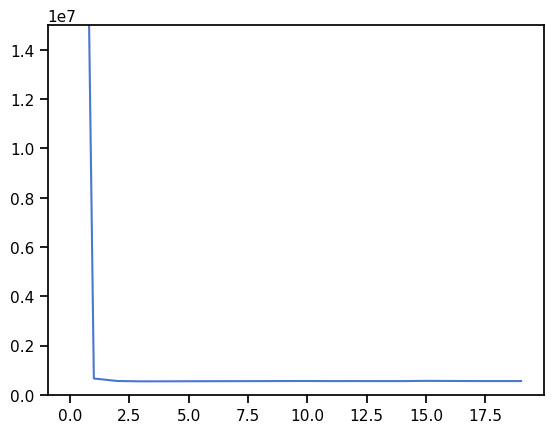

In [87]:
plt.plot(test[0:])
plt.ylim([0,1.5e7])

In [28]:
alpha = res['track']['alphas'][0]
Ups = res['track']['Upss'][0]

In [29]:
Ks = [5, 10, 20]
K = 10
mu = 2.3
L = 25
num_seeds = 200

In [30]:
seed_mod = 0
seeds = [x + seed_mod for x in range(num_seeds)]
# sps = [int(1e4), int(5e4)]
scale_power = int(5e4)
plot_dict = get_plot_dict(eigval_all_pushforward_model_true_oracle, cfg, cfg_lr, scale_power, K, L, mu, seeds)

In [31]:
sorted_naive = jnp.stack(plot_dict['naive']).sort(0)/K
naive_low = sorted_naive[5,:]
naive_high = sorted_naive[195,:]

sorted_model = jnp.stack(plot_dict['model']).sort(0)/K
model_low = sorted_model[5,:]
model_high = sorted_model[195,:]

sorted_oracle = jnp.stack(plot_dict['oracle']).sort(0)/K
oracle_low = sorted_oracle[5,:]
oracle_high = sorted_oracle[195,:]

In [34]:
import seaborn as sns
sns.set_palette('muted')
current_palette = sns.color_palette()
sns.set_context("notebook")

In [33]:
save_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/lr_figures/2'

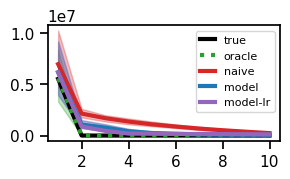

In [35]:
# func = jnp.log
# func = lambda x: jnp.log(x + 1e-1)
# func = lambda x: jnp.log(jnp.abs(x))
func = lambda x: x
# alf = 0.2
# for n in range(nseeds):
#     plt.plot(func(plot_dict['naive'][n]), color='tab:red', alpha=alf)
#     plt.plot(func(plot_dict['model'][n]), color='tab:blue', alpha=alf)
#     plt.plot(func(plot_dict['oracle'][n]), color='tab:green', alpha=alf)


x = jnp.arange(K) + 1
fig, ax = plt.subplots(figsize=(3,1.5))
true_dummy = jnp.zeros(K)
# true_dummy = true_dummy.at[0].set(plot_dict['true'][0].squeeze())
mw = 3
# ax.plot(x, func(true_dummy)/K, color='k', linewidth=mw, label='true')
ax.plot(x, func(jnp.stack(plot_dict['true'])).mean(0)/K, color='k', linewidth=mw, label='true')
ax.plot(x, func(jnp.stack(plot_dict['oracle'])).mean(0)/K,  linestyle='dotted', linewidth=mw, color='tab:green', label='oracle')
ax.fill_between(x, oracle_low, oracle_high, color='tab:green', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['naive'])).mean(0)/K, linewidth=mw, color='tab:red', label='naive')
ax.fill_between(x, naive_low, naive_high, color='tab:red', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['model'])).mean(0)/K, linewidth=mw, color='tab:blue', label='model')
ax.fill_between(x, model_low, model_high, color='tab:blue', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['model_lr'])).mean(0)/K, linewidth=mw, color='tab:purple', label='model-lr')
ax.fill_between(x, model_low, model_high, color='tab:purple', alpha=0.3)
# ax.set_ylabel(r'$\hat{\lambda}/K$')
# ax.set_xlabel('Eigenvalue Index')
# ax.set_ylim([0,80000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# ax.set_title(r'$\mu_{e}$=2.5' + ' spikes/sec; L = 25')
# ax.set_title(r'$\mu$=2.5' + ' spikes/sec; L = 25$')
plt.legend(fontsize=8, handlelength=1.3)
# ax.set_xlim(0,5)
save_name = os.path.join(save_path, '2eigvals_all.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")


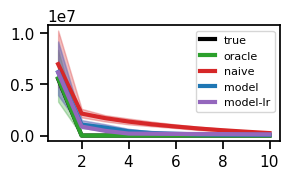

In [36]:
# func = jnp.log
# func = lambda x: jnp.log(x + 1e-1)
# func = lambda x: jnp.log(jnp.abs(x))
func = lambda x: x
# alf = 0.2
# for n in range(nseeds):
#     plt.plot(func(plot_dict['naive'][n]), color='tab:red', alpha=alf)
#     plt.plot(func(plot_dict['model'][n]), color='tab:blue', alpha=alf)
#     plt.plot(func(plot_dict['oracle'][n]), color='tab:green', alpha=alf)


x = jnp.arange(K) + 1
fig, ax = plt.subplots(figsize=(3,1.5))
true_dummy = jnp.zeros(K)
# true_dummy = true_dummy.at[0].set(plot_dict['true'][0].squeeze())
mw = 3
# ax.plot(x, func(true_dummy)/K, color='k', linewidth=mw, label='true')
ax.plot(x, func(jnp.stack(plot_dict['true'])).mean(0)/K, color='k', linewidth=mw, label='true')
ax.plot(x, func(jnp.stack(plot_dict['oracle'])).mean(0)/K, linewidth=mw, color='tab:green', label='oracle')
ax.fill_between(x, oracle_low, oracle_high, color='tab:green', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['naive'])).mean(0)/K, linewidth=mw, color='tab:red', label='naive')
ax.fill_between(x, naive_low, naive_high, color='tab:red', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['model'])).mean(0)/K, linewidth=mw, color='tab:blue', label='model')
ax.fill_between(x, model_low, model_high, color='tab:blue', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['model_lr'])).mean(0)/K, linewidth=mw, color='tab:purple', label='model-lr')
ax.fill_between(x, model_low, model_high, color='tab:purple', alpha=0.3)
# ax.set_ylabel(r'$\hat{\lambda}/K$')
# ax.set_xlabel('Eigenvalue Index')
# ax.set_ylim([0,80000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# ax.set_title(r'$\mu_{e}$=2.5' + ' spikes/sec; L = 25')
# ax.set_title(r'$\mu$=2.5' + ' spikes/sec; L = 25$')
plt.legend(fontsize=8, handlelength=1.3)
# ax.set_xlim(0,5)
save_name = os.path.join(save_path, '2eigvals_all_dummy_legend.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")


In [40]:
Ks = [5, 10, 20]
K = 10
mu = 2.3
L = 25
num_seeds = 200
seed_mod = 0
seeds = [x + seed_mod for x in range(num_seeds)]
# sps = [int(1e4), int(5e4)]
scale_power = int(5e4)
plot_dict = get_plot_dict(eigval_all, cfg, cfg_lr, scale_power, K, L, mu, seeds)

In [41]:
sorted_naive = jnp.stack(plot_dict['naive']).sort(0)/K
naive_low = sorted_naive[5,:]
naive_high = sorted_naive[195,:]

sorted_model = jnp.stack(plot_dict['model']).sort(0)/K
model_low = sorted_model[5,:]
model_high = sorted_model[195,:]

sorted_oracle = jnp.stack(plot_dict['oracle']).sort(0)/K
oracle_low = sorted_oracle[5,:]
oracle_high = sorted_oracle[195,:]

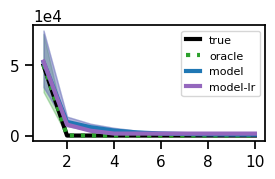

In [42]:
# func = jnp.log
# func = lambda x: jnp.log(x + 1e-1)
# func = lambda x: jnp.log(jnp.abs(x))
func = lambda x: x
# alf = 0.2
# for n in range(nseeds):
#     plt.plot(func(plot_dict['naive'][n]), color='tab:red', alpha=alf)
#     plt.plot(func(plot_dict['model'][n]), color='tab:blue', alpha=alf)
#     plt.plot(func(plot_dict['oracle'][n]), color='tab:green', alpha=alf)


x = jnp.arange(K) + 1
fig, ax = plt.subplots(figsize=(3,1.5))
true_dummy = jnp.zeros(K)
true_dummy = true_dummy.at[0].set(plot_dict['true'][0].squeeze())
mw = 3
ax.plot(x, func(true_dummy)/K, color='k', linewidth=mw, label='true')
# ax.plot(x, func(jnp.stack(plot_dict['true'])).mean(0)/K, color='k', linewidth=mw, label='true')
ax.plot(x, func(jnp.stack(plot_dict['oracle'])).mean(0)/K,  linestyle='dotted', linewidth=mw, color='tab:green', label='oracle')
ax.fill_between(x, oracle_low, oracle_high, color='tab:green', alpha=0.3)
# ax.plot(x, func(jnp.stack(plot_dict['naive'])).mean(0)/K, linewidth=mw, color='tab:red', label='naive')
# ax.fill_between(x, naive_low, naive_high, color='tab:red', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['model'])).mean(0)/K, linewidth=mw, color='tab:blue', label='model')
ax.fill_between(x, model_low, model_high, color='tab:blue', alpha=0.3)
ax.plot(x, func(jnp.stack(plot_dict['model_lr'])).mean(0)/K, linewidth=mw, color='tab:purple', label='model-lr')
ax.fill_between(x, model_low, model_high, color='tab:purple', alpha=0.3)
# ax.set_ylabel(r'$\hat{\lambda}/K$')
# ax.set_xlabel('Eigenvalue Index')
# ax.set_ylim([0,80000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# ax.set_title(r'$\mu_{e}$=2.5' + ' spikes/sec; L = 25')
# ax.set_title(r'$\mu$=2.5' + ' spikes/sec; L = 25$')
plt.legend(fontsize=8, handlelength=1.3)
# ax.set_xlim(0,5)
save_name = os.path.join(save_path, '2eigvals_latentscale.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")


In [37]:
def plot_sampling_dists_violin(ax, data_matrix, category_labels, alpha=0.5, violin_colors=None):
    """
    Plot data points from a matrix across multiple categories.

    Parameters:
    - data_matrix: numpy array or matrix of shape (N, C), with N data points per each of the C categories.
    - category_labels: List of category labels (length C).
    """
    N, C = data_matrix.shape
    x_positions = np.arange(C)

    if violin_colors is None:
        violin_colors = ['tab:blue' for x in range(C)]
    elif type(violin_colors) is str:
        violin_colors_temp = [violin_colors for x in range(C)]
        violin_colors = violin_colors_temp
    elif type(violin_colors) is list:
        assert len(violin_colors) == C

    violins = ax.violinplot(data_matrix, positions=np.arange(C), showmeans=True)

    # Set colors individually
    for i, pc in enumerate(violins['bodies']):
        pc.set_facecolor(violin_colors[i])
        pc.set_alpha(alpha)
        pc.set_edgecolor('k')
        pc.set_linewidth(1)

    # Customize lines (mean, min-max)
    # for partname in ('cbars','cmins','cmaxes','cmeans'):
    for partname in ('cbars','cmeans'):
        vp = violins[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)

    for partname in ('cbars','cmins','cmaxes'):
        vp = violins[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(0)


    cap_width = 0.1
    positions = np.arange(C)
    for i, pos in enumerate(positions):
        quartile1, quartile3 = np.percentile(data_matrix[:, i], [25, 75])

        # Draw vertical line connecting quartiles
        ax.vlines(pos, quartile1, quartile3, color='black', linestyle='-', linewidth=1.5)

        # Draw horizontal cap lines at quartiles
        ax.hlines([quartile1, quartile3], pos - cap_width, pos + cap_width, color='black', linewidth=1.5)

    # ax.violinplot(data_matrix, positions=np.arange(len(category_labels)), showmeans=True)

    ax.set_xticks(x_positions, category_labels)
    plt.tight_layout()

In [38]:
mu = 2.3
Ks = [5, 10, 20]
L = 25
num_seeds = 200
seed_mod = 0
seeds = [x + seed_mod for x in range(num_seeds)]
# sps = [int(1e4), int(5e4)]
scale_power = int(5e4)

In [40]:
naive_list = []
model_list = []
model_lr_list = []
oracle_list = []
true_vals = []
for K in Ks:
    plot_dict = get_plot_dict(eigval1_pushforward_model_true_oracle, cfg, cfg_lr, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive'])/K)
    oracle_list.append(jnp.array(plot_dict['oracle'])/K)
    model_list.append(jnp.array(plot_dict['model'])/K)
    model_lr_list.append(jnp.array(plot_dict['model_lr'])/K)
    true_vals.append(plot_dict['true'][0]/K)

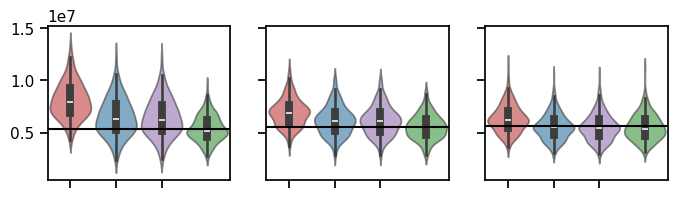

In [49]:
# fig, ax = plt.subplots(figsize=(2.5,2))
fig, ax = plt.subplots(1,3,figsize=(8,2), sharey=True)
for Kind, K in enumerate(Ks):
    data = np.vstack([naive_list[Kind], model_list[Kind], model_lr_list[Kind], oracle_list[Kind]]).T
    colors = ['tab:red', 'tab:blue', 'tab:purple', 'tab:green']
    sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box', ax=ax[Kind])
    ax[Kind].axhline(true_vals[Kind], color='k')
    ax[Kind].set_xticks([0,1,2])
    ax[Kind].set_xticklabels([])
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    # ax[Kind].set_ylim([10000,110000])
    # ax.set_ylim([0,1.5e7])

save_name = os.path.join(save_path, f'2eigval1K_lr.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

    # ax.set_title(f'K = {Ks[Kind]}')

In [50]:
naive_list = []
model_list = []
model_lr_list = []
oracle_list = []
true_vals = []
for K in Ks:
    plot_dict = get_plot_dict(eigval1, cfg, cfg_lr, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive'])/K)
    oracle_list.append(jnp.array(plot_dict['oracle'])/K)
    model_list.append(jnp.array(plot_dict['model'])/K)
    model_lr_list.append(jnp.array(plot_dict['model_lr'])/K)
    true_vals.append(plot_dict['true'][0]/K)

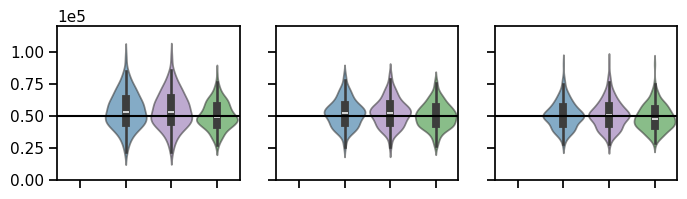

In [52]:
Ks = [5, 10, 20]
Kind = 2
# fig, ax = plt.subplots(figsize=(2.5,2))
fig, ax = plt.subplots(1,3,figsize=(8,2), sharey=True)
for Kind, K in enumerate(Ks):
    data = np.vstack([naive_list[Kind], model_list[Kind], model_lr_list[Kind], oracle_list[Kind]]).T
    colors = ['tab:red', 'tab:blue', 'tab:purple', 'tab:green']
    sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box', ax=ax[Kind])
    ax[Kind].axhline(true_vals[Kind], color='k')
    ax[Kind].set_xticks([0,1,2,3])
    ax[Kind].set_xticklabels([])
    # ax.set_ylim([10000,110000])
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax[Kind].set_ylim([0,1.2e5])

save_name = os.path.join(save_path, f'2eigval1K_latentscale_lr.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

    # ax.set_title(f'K = {Ks[Kind]}')

In [41]:
naive_list = []
model_list = []
model_lr_list = []
oracle_list = []
for K in Ks:
    # plot_dict = get_plot_dict(eigval1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    plot_dict = get_plot_dict(gcoh_pushforward_model_true_oracle, cfg, cfg_lr, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive']))
    oracle_list.append(jnp.array(plot_dict['oracle']))
    model_list.append(jnp.array(plot_dict['model']))
    model_lr_list.append(jnp.array(plot_dict['model_lr']))

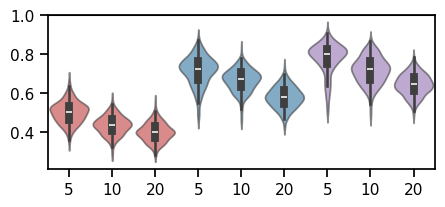

In [42]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,2))
data0 = np.vstack(naive_list).T
data1 = np.vstack(model_list).T
data2 = np.vstack(model_lr_list).T
data = jnp.hstack([data0, data1, data2])

colors = ['tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:purple', 'tab:purple']

sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(['5', '10', '20', '5', '10', '20', '5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

save_name = os.path.join(save_path, f'2gcoh.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

In [99]:
naive_list = []
model_list = []
model_lr_list = []
oracle_list = []
for K in Ks:
    # plot_dict = get_plot_dict(eigval1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    plot_dict = get_plot_dict(gcoh_pushforward_model_true_oracle_bbh, cfg, cfg_lr, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive']))
    oracle_list.append(jnp.array(plot_dict['oracle']))
    model_list.append(jnp.array(plot_dict['model']))
    model_lr_list.append(jnp.array(plot_dict['model_lr']))

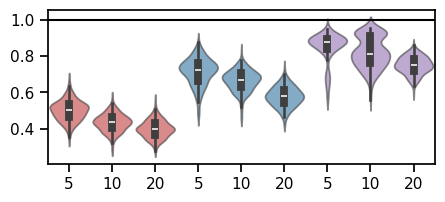

In [100]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,2))
data0 = np.vstack(naive_list).T
data1 = np.vstack(model_list).T
data2 = np.vstack(model_lr_list).T
data = jnp.hstack([data0, data1, data2])

colors = ['tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:purple', 'tab:purple']

sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(['5', '10', '20', '5', '10', '20', '5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

save_name = os.path.join(save_path, f'2gcoh_bbh.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

(0.0, 1.05)

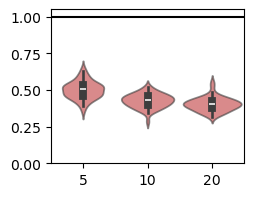

In [58]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(naive_list).T
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:red', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
ax.set_ylim([0.0,1.05])

(0.0, 1.05)

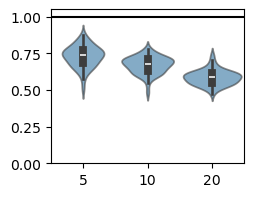

In [59]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(2.5,2))
data = np.vstack(model_list).T
test = ['tab:blue', 'tab:red', 'tab:green']
sns.violinplot(data=data, width=1.0, gap=0.1, color='tab:blue', alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2])
ax.set_xticklabels(['5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
# ax.set_ylim([0,1.5e7])
ax.set_ylim([0.0,1.05])

In [23]:
Ks = [5, 10, 20]
K = 10
mu = 2.3
L = 25
num_seeds = 200

In [43]:
naive_list = []
model_list = []
model_lr_list = []
oracle_list = []
for K in Ks:
    # plot_dict = get_plot_dict(eigval1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    plot_dict = get_plot_dict(gcoh, cfg, cfg_lr, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive']))
    oracle_list.append(jnp.array(plot_dict['oracle']))
    model_list.append(jnp.array(plot_dict['model']))
    model_lr_list.append(jnp.array(plot_dict['model_lr']))

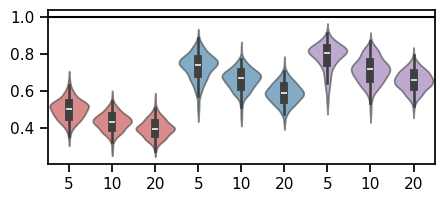

In [44]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,2))
data0 = np.vstack(naive_list).T
data1 = np.vstack(model_list).T
data2 = np.vstack(model_lr_list).T
data = jnp.hstack([data0, data1, data2])

colors = ['tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:purple', 'tab:purple']

sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(['5', '10', '20', '5', '10', '20', '5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

save_name = os.path.join(save_path, f'2gcoh_latent.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

In [45]:
naive_list = []
model_list = []
model_lr_list = []
oracle_list = []
for K in Ks:
    # plot_dict = get_plot_dict(eigval1_pushforward_model_true_oracle, cfg, scale_power, K, L, mu, seeds)
    plot_dict = get_plot_dict(gcoh_bbh, cfg, cfg_lr, scale_power, K, L, mu, seeds)
    naive_list.append(jnp.array(plot_dict['naive']))
    oracle_list.append(jnp.array(plot_dict['oracle']))
    model_list.append(jnp.array(plot_dict['model']))
    model_lr_list.append(jnp.array(plot_dict['model_lr']))

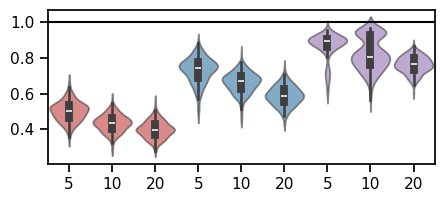

In [33]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5,2))
data0 = np.vstack(naive_list).T
data1 = np.vstack(model_list).T
data2 = np.vstack(model_lr_list).T
data = jnp.hstack([data0, data1, data2])

colors = ['tab:red', 'tab:red', 'tab:red', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:purple', 'tab:purple', 'tab:purple']

sns.violinplot(data=data, width=1.0, gap=0.1, palette=colors, alpha=0.6, inner='box')
ax.axhline(plot_dict['true'][0], color='k')
ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_xticklabels(['5', '10', '20', '5', '10', '20', '5', '10', '20'])
# ax.set_ylim([10000,110000])
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

save_name = os.path.join(save_path, f'2gcoh_latent_bbh.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

In [25]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

def plot_complex_std_contours(means, std_reals, std_imags, ax=None, n_std=1.0, colors=None, alpha=0.3):
    """
    Plot ellipses representing the standard deviations of complex-valued scalar random variables.
    
    Parameters:
        means: array-like of complex
            Complex means (centers of ellipses)
        std_reals: array-like of float
            Standard deviations of real parts
        std_imags: array-like of float
            Standard deviations of imaginary parts
        ax: matplotlib Axes, optional
            Axis to plot on. If None, a new figure and axis are created.
        n_std: float
            Number of standard deviations to scale the ellipse (default 1.0)
        colors: list of str, optional
            Colors for each ellipse. If None, default matplotlib colors are used.
        alpha: float
            Transparency of the ellipses
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    if colors is None:
        colors = plt.cm.tab10(np.arange(len(means)) % 10)

    for i, (mu, std_r, std_i) in enumerate(zip(means, std_reals, std_imags)):
        ellipse = Ellipse(
            xy=(mu.real, mu.imag),
            width=2 * n_std * std_r,
            height=2 * n_std * std_i,
            edgecolor=colors[i],
            facecolor=colors[i],
            alpha=alpha,
            label=f'RV {i+1}'
        )
        ax.add_patch(ellipse)
        ax.plot(mu.real, mu.imag, 'o', color=colors[i])  # mean point


In [29]:
def plot_complex_bounds_contours(means, real_lows, real_highs, imag_lows, imag_highs, ax=None, colors=None, alpha=0.3):
    """
    Plot ellipses representing the specified real and imaginary bounds for complex-valued scalar RVs.

    Parameters:
        real_lows, real_highs: array-like of floats
            Lower and upper bounds for the real parts
        imag_lows, imag_highs: array-like of floats
            Lower and upper bounds for the imaginary parts
        ax: matplotlib Axes, optional
            Axis to plot on. If None, a new figure and axis are created.
        colors: list of str, optional
            Colors for each ellipse. If None, default matplotlib colors are used.
        alpha: float
            Transparency of the ellipses
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    N = len(real_lows)
    if colors is None:
        colors = plt.cm.tab10(np.arange(N) % 10)

    labels = ['naive', 'model', 'model-lr', 'oracle']
    markers = ['s', 'o', 'x', '^']
    for i in range(N):
        # Compute ellipse center and width/height
        center_real = (real_lows[i] + real_highs[i]) / 2
        center_imag = (imag_lows[i] + imag_highs[i]) / 2
        width = real_highs[i] - real_lows[i]
        height = imag_highs[i] - imag_lows[i]
        # print(labels[i])
        # print(colors[i])

        if i == 1 or i == 2:
            if i == 1:
                istyle = 'dotted'
                ecolor = colors[i]
            if i == 2:
                istyle = '-'
                ecolor = colors[i]
            fcolor = 'none'
            alpha = 1
        else:
            istyle = 'none'
            fcolor = colors[i]
            alpha = 0.3
            ecolor = colors[i]

        if i == 2:
            # hatch = '/'
            hatch = None
            lw = 2
        else: 
            hatch = None
            lw = 3
        # print(ecolor)
        # if i == 0:
        #     ecolor = 'none'
        # else:
        #     ecolor = colors[i]

        ellipse = Ellipse(
            xy=(center_real, center_imag),
            width=width,
            height=height,
            # edgecolor=colors[i],
            edgecolor=ecolor,
            facecolor=fcolor,
            hatch=hatch,
            alpha=alpha,
            linestyle=istyle,
            linewidth=lw
        )
        ax.add_patch(ellipse)
        # ax.plot(center_real, center_imag, 'o', color=colors[i])  # center point
        ax.plot(means.real, means.imag, marker=markers[i], markersize=5, color=colors[i], label=labels[i], linestyle=None)  # mean point

In [19]:
from cohlib.plot import get_eigvec
from cohlib.utils import rotate_eigvecs
def eigvec1(cfg, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    eigvec_true = lrccn_true.eigvecs[0,:,eigrank-1]

    # eigvec_model = rotate_eigvecs(get_ccn_fullrank_eigvecs(res['ccn_est']))[0,:,eigrank-1]
    eigvec_model = get_ccn_fullrank_eigvecs(res['ccn_est'])[0,:,eigrank-1]

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    eigvec_oracle = get_eigvec(gamma_oracle[jind_nz,:,:], eigrank)
    # eigvec_oracle = eigvec_oracle*jnp.exp(-1j*jnp.angle(eigvec_oracle[0]))

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigvec_naive = get_eigvec(naive_est[jind_nz,:,:], eigrank)
    # eigvec_naive = eigvec_naive*jnp.exp(-1j*jnp.angle(eigvec_naive[0]))

    return eigvec_true, eigvec_oracle, eigvec_model, eigvec_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [20]:
def eigvec1_pushforward_model_true_oracle(cfg, cfg_lr, seed, eigrank=1, gseed=0, jind_nz=0):
    cfg.latent.gamma_seed = gseed
    cfg.latent.seed = seed
    cfg.obs.seed = seed
    cfg_lr.latent.gamma_seed = gseed
    cfg_lr.latent.seed = seed
    cfg_lr.obs.seed = seed
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    K = cfg.latent.K
    mu = cfg.obs.mu
    mus = jnp.repeat(mu, K)

    latent_dir = conf.get_latent_dir(cfg.latent)
    latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))

    obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
    obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))


    freqs = latent_load['freqs']

    temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
            'nz_model': nz_model, 'K': cfg.latent.K}
    model_dir = conf.get_model_dir(cfg, temp_params)

    res = pickle_open(os.path.join(model_dir, 'res.pkl'))

    lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
    # eigvec_true = lrccn_true.eigvecs[0,:,eigrank-1]
    gamma_true_pushforward_mc = get_pushforward_lrccn_mc(lrccn_true, nz_model)
    eigvecs_true = jnp.linalg.eigh(gamma_true_pushforward_mc.squeeze())[1][:,::-1]
    eigvec_true = rotate_eigvecs(eigvecs_true[None,:,:])[0,:,eigrank-1]

    # eigvec_model = rotate_eigvecs(get_ccn_fullrank_eigvecs(res['ccn_est']))[0,:,eigrank-1]
    gamma_model_pushforward_mc = get_pushforward_model_est_mc(res, mus, nz_model, freqs)
    # gamma_model_pushforward_mc = get_pushforward_lrccn_mc(lrccn_true, nz_model)
    eigvecs_model = jnp.linalg.eigh(gamma_model_pushforward_mc.squeeze())[1][:,::-1]
    eigvec_model = rotate_eigvecs(eigvecs_model[None,:,:])[0,:,eigrank-1]

    model_dir_lr = conf.get_model_dir(cfg_lr, temp_params)
    res_lr = pickle_open(os.path.join(model_dir_lr, 'res.pkl'))

    gamma_model_lr_pushforward_mc = get_pushforward_model_est_mc(res_lr, mus, nz_model, freqs)
    gamma_model_lr_pushforward_mc = gamma_model_lr_pushforward_mc.squeeze()
    eigvecs_model_lr = jnp.linalg.eigh(gamma_model_lr_pushforward_mc.squeeze())[1][:,::-1]
    eigvec_model_lr = rotate_eigvecs(eigvecs_model_lr[None,:,:])[0,:,eigrank-1]

    zs_nz = latent_load['zs_nz']
    nz_true = latent_load['nz']

    # gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
    gamma_oracle_eigvals = jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] 
    gamma_oracle_eigvecs = jnp.linalg.eigh(gamma_oracle.squeeze())[1][:,::-1] 
    num_psd_eigvals = (jnp.linalg.eigh(gamma_oracle.squeeze())[0][::-1] >= 0).sum()
    # num_psd_eigvals = 1
    print(num_psd_eigvals)

    lrccn_oracle = conf.create_lrccn_basic_rank1(cfg.latent)
    lrccn_oracle.eigvals = gamma_oracle_eigvals[None,:num_psd_eigvals]
    lrccn_oracle.eigvecs = gamma_oracle_eigvecs[None,:,:num_psd_eigvals]
    gamma_oracle_pushforward_mc = get_pushforward_lrccn_mc(lrccn_oracle, nz_model)
    # eigvecs_oracle = jnp.linalg.eigh(gamma_oracle_pushforward_mc)[1][:,::-1]
    # eigvec_oracle = rotate_eigvecs(eigvecs_oracle[None,:,:])[0,:,eigrank-1].squeeze()

    eigvec_oracle = get_eigvec(gamma_oracle_pushforward_mc.squeeze(), eigrank)
    eigvec_oracle = eigvec_oracle*jnp.exp(-1j*jnp.angle(eigvec_oracle[0]))

    obs = obs_load['obs']

    if cfg.model.inherit_lcfg is True:
        nz_model = nz_true
    else:
        raise NotImplementedError

    obs_type = cfg.obs.obs_type
    if obs_type == 'gaussian':
        naive_est = naive_estimator(obs, nz_model)
    elif obs_type in ['pp_relu', 'pp_log']:
        naive_est = naive_estimator(obs, nz_model)*1e6
    else:
        raise ValueError
    eigvecs_naive = jnp.linalg.eigh(naive_est)[1][:,::-1]
    # eigvec_naive = rotate_eigvecs(eigvecs_naive[None,:,:])[0,:,eigrank-1].squeeze()
    eigvec_naive = get_eigvec(naive_est[jind_nz,:,:], eigrank)
    eigvec_naive = eigvec_naive*jnp.exp(-1j*jnp.angle(eigvec_naive[0]))

    return eigvec_true, eigvec_oracle, eigvec_model, eigvec_model_lr, eigvec_naive

# L = 5; mu = 0.8; K = 3
# get and store naive; oracle; true; model values


In [21]:
num_seeds = 200
seed_mod = 0
L = 25
mu = 2.3
seeds = [x + seed_mod for x in range(num_seeds)]
dim = 2
datas = []
trues = []
Ks = [5, 10, 20]
for i, K in enumerate(Ks):
    plot_dict = get_plot_dict(eigvec1_pushforward_model_true_oracle, cfg, cfg_lr, scale_power, K, L, mu, seeds)
    data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['model_lr']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    # data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model'])]).swapaxes(0,1)# / K
    # data_raw = jnp.stack([jnp.array(plot_dict['naive'])]).swapaxes(0,1)# / K
    datas.append(data_raw)

    true = plot_dict['true'][0]
    trues.append(true)

3
3
4
2
4
3
3
2
3
3
4
2
3
4
3
3
3
3
3
4
2
4
3
3
3
2
4
3
2
3
3
4
2
4
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
2
2
2
3
4
3
3
3
3
3
2
3
3
4
3
3
2
3
2
3
4
3
3
3
3
3
3
3
3
3
3
4
4
4
4
3
4
2
4
4
3
3
4
3
3
3
3
2
3
3
3
3
2
4
3
3
3
3
3
3
3
4
2
3
2
3
2
3
3
3
3
3
3
3
3
3
3
3
3
3
4
2
3
3
3
4
3
3
3
4
3
3
3
3
3
3
2
2
2
3
2
2
4
3
3
4
3
4
4
2
4
3
3
3
3
3
3
3
2
3
2
2
2
3
3
4
3
3
2
4
3
3
3
2
3
3
2
3
2
3
3
3
3
3
3
4
4
2
5
5
5
6
6
5
6
6
5
5
4
7
6
5
4
5
6
5
6
5
5
6
6
6
6
5
6
6
6
5
5
5
5
7
5
6
5
6
5
4
6
5
5
6
6
5
6
5
6
5
6
6
5
5
5
4
5
6
6
5
6
4
5
6
6
6
5
5
6
5
5
5
6
6
5
5
5
6
5
5
6
5
5
5
5
6
5
5
6
6
6
6
5
5
5
5
6
5
6
6
6
5
5
4
5
5
5
6
5
5
5
6
6
5
6
7
5
5
5
6
5
5
5
5
6
7
5
6
5
6
6
6
7
5
7
5
5
5
5
5
6
6
6
7
4
5
4
6
5
5
5
5
4
6
5
7
5
5
5
6
5
5
5
6
4
7
4
6
6
5
6
6
5
5
6
5
6
6
6
6
5
5
5
6
6
5
5
5
5
5
5
6
5
6
4
7
6
5
6
7
10
11
10
9
9
9
11
10
11
10
11
10
10
12
11
10
10
11
11
10
10
9
10
10
12
11
10
10
10
9
9
11
11
10
12
11
11
11
10
12
11
9
10
11
12
10
11
10
10
11
11
12
11
11
11
11
12
11
12
11
11
10
11
11
9
9
9
9
10
11
1

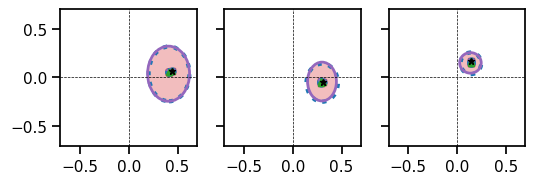

In [31]:
dim = 4
fig, ax = plt.subplots(1,3,figsize=(6,3), sharey=True)
for i, K in enumerate(Ks):
    data = datas[i][:,:,dim]
    true = trues[i][dim]
    # plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    # data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    # data = data_raw[:,:,dim]

    means = data.mean(0)
    reals_low = data.real.sort(0)[5,:]
    reals_high = data.real.sort(0)[195,:]
    imags_low = data.imag.sort(0)[5,:]
    imags_high = data.imag.sort(0)[195,:]
    # colors = ['tab:red', 'tab:blue']
    colors = ['tab:red', 'tab:blue', 'tab:purple', 'tab:green']
    plot_complex_bounds_contours(means, reals_low, reals_high, imags_low, imags_high, ax=ax[i], colors=colors, alpha=0.3)
    ax[i].plot(true.real, true.imag, color='k', marker='*', markersize=5, label='true', linestyle=None)
    ax[i].axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].set_xlim([-0.7, 0.7])
    ax[i].set_ylim([-0.7, 0.7])
    # ax.set_xlabel('Real')
    # if i == 0:
    #     ax.set_ylabel('Imag')
    #     # ax.legend()
    ax[i].set_aspect('equal')
    # ax[i].legend()
    # ax.set_title(f'K = {K}')
    # plt.grid(True)
    
save_name = os.path.join(save_path, f'2eigvec1.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

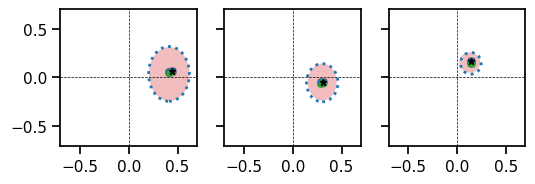

In [37]:
dim = 4
fig, ax = plt.subplots(1,3,figsize=(6,3), sharey=True)
for i, K in enumerate(Ks):
    data = datas[i][:,:,dim]
    true = trues[i][dim]
    # plot_dict = get_plot_dict(eigvec1, cfg, scale_power, K, L, mu, seeds)
    # data_raw = jnp.stack([jnp.array(plot_dict['naive']), jnp.array(plot_dict['model']), jnp.array(plot_dict['oracle'])]).swapaxes(0,1)# / K
    # data = data_raw[:,:,dim]

    means = data.mean(0)
    reals_low = data.real.sort(0)[5,:]
    reals_high = data.real.sort(0)[195,:]
    imags_low = data.imag.sort(0)[5,:]
    imags_high = data.imag.sort(0)[195,:]
    # colors = ['tab:red', 'tab:blue']
    colors = ['tab:red', 'tab:blue', 'tab:green']
    plot_complex_bounds_contours(means, reals_low, reals_high, imags_low, imags_high, ax=ax[i], colors=colors, alpha=0.3)
    ax[i].plot(true.real, true.imag, color='k', marker='*', markersize=5, label='true', linestyle=None)
    ax[i].axhline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].axvline(0, color='k', linestyle='--', linewidth=0.5)
    ax[i].set_xlim([-0.7, 0.7])
    ax[i].set_ylim([-0.7, 0.7])
    # ax.set_xlabel('Real')
    # if i == 0:
    #     ax.set_ylabel('Imag')
    #     # ax.legend()
    ax[i].set_aspect('equal')
    # ax[i].legend()
    # ax.set_title(f'K = {K}')
    # plt.grid(True)
    
save_name = os.path.join(save_path, f'2eigvec1.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")

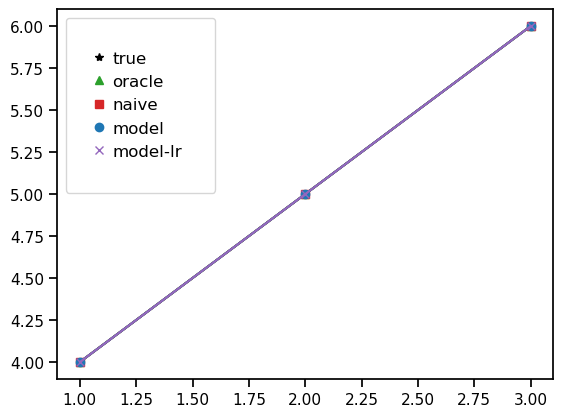

In [38]:
plt.rcParams['legend.handlelength'] = 0

plt.plot([1, 2, 3], [4, 5, 6], color='k', marker='*', label='true')
plt.plot([1, 2, 3], [4, 5, 6], color='tab:green', marker='^', label='oracle')
plt.plot([1, 2, 3], [4, 5, 6], color='tab:red', marker='s', label='naive')
plt.plot([1, 2, 3], [4, 5, 6], color='tab:blue', marker='o', label='model')
plt.plot([1, 2, 3], [4, 5, 6], color='tab:purple', marker='x', label='model-lr')
plt.legend(fontsize=12, borderpad=2)
save_name = os.path.join(save_path, f'2dummy_evec.png')
plt.savefig(save_name, dpi=600, bbox_inches="tight")